<a href="https://colab.research.google.com/github/ImranTD11/Assignment-01/blob/main/Copy_of_M1_new_room_on_airbnb_train_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Price Prediction in Copenhagen

This notebook demonstrates the process of building a machine learning model to predict Airbnb prices in Copenhagen. We'll go through data loading, preprocessing, feature engineering, model training, and evaluation, with a focus on handling imbalanced data, imputation, and model explainability.

## Setup and Data Loading

First, let's install the required libraries and import the necessary modules.

In [ ]:
!pip install xgboost -q
!pip install shap -q
!pip install imbalanced-learn -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBRegressor
import shap
import joblib

# Load the data
data = pd.read_csv('http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2022-06-24/data/listings.csv.gz')

## Data Preprocessing and Exploratory Data Analysis

Let's clean the data and prepare it for analysis. We'll also perform some initial exploratory data analysis to understand our dataset better.

In [ ]:
# Display initial information about the dataset
data.info()

# Clean price column
data['price'] = data.price.str.replace('$', '').str.replace(',', '').astype('float')

# Convert instant_bookable to boolean
data['instant_bookable'] = data['instant_bookable'].map({'f': False, 't': True})

# Filter data
data = data[data.room_type.isin(['Private room', 'Entire home/apt'])]
data = data[data.number_of_reviews_l30d >= 1]
data = data[data.review_scores_rating >= 4]

# Remove outliers
data['price_z'] = (data['price'] - data['price'].mean()) / data['price'].std(ddof=0)
data = data[data.price_z.abs() < 2]

print("Data shape after initial filtering:", data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12495 non-null  int64  
 1   listing_url                                   12495 non-null  object 
 2   scrape_id                                     12495 non-null  int64  
 3   last_scraped                                  12495 non-null  object 
 4   name                                          12495 non-null  object 
 5   description                                   12156 non-null  object 
 6   neighborhood_overview                         6461 non-null   object 
 7   picture_url                                   12495 non-null  object 
 8   host_id                                       12495 non-null  int64  
 9   host_url                                      12495 non-null 

### Explanation of Filtering Steps

1. **Room Type Filter**: We focus on 'Private room' and 'Entire home/apt' as these are the most common and relevant types for typical Airbnb users. This helps us create a more focused model.

2. **Recent Reviews Filter**: By keeping listings with at least one review in the last 30 days, we ensure our data represents active and current listings, improving the relevance of our predictions.

3. **High Rating Filter**: Filtering for listings with ratings of 4 or above helps us focus on quality accommodations, which are more likely to have consistent pricing patterns.

4. **Outlier Removal**: We remove price outliers using z-scores. This step is crucial because extreme prices (very low or very high) can disproportionately influence our model, leading to poor generalization. By removing listings with z-scores greater than 2 (roughly the top and bottom 2.5% of prices), we focus on the more typical price range.

These filtering steps help us create a cleaner, more relevant dataset, which should lead to a more accurate and useful predictive model.

## Feature Selection

Now, let's select the features we'll use for our model.

In [ ]:
# Select features
selected_features = ['neighbourhood_cleansed', 'room_type', 'instant_bookable', 'accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'price']
df = data[selected_features]

# Display information about selected features
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3831 entries, 0 to 12490
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  3831 non-null   object 
 1   room_type               3831 non-null   object 
 2   instant_bookable        3831 non-null   bool   
 3   accommodates            3831 non-null   int64  
 4   bedrooms                3761 non-null   float64
 5   beds                    3785 non-null   float64
 6   minimum_nights_avg_ntm  3831 non-null   float64
 7   price                   3831 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(2)
memory usage: 243.2+ KB


### Explanation of Feature Selection

We've chosen these features based on their likely impact on price:

- `neighbourhood_cleansed`: Location is often a key factor in accommodation pricing.
- `room_type`: The type of space (entire home vs. private room) significantly affects price.
- `instant_bookable`: This feature might influence pricing strategy.
- `accommodates`: The number of guests a listing can host is usually reflected in its price.
- `bedrooms` and `beds`: These features directly relate to the size and capacity of the listing.
- `minimum_nights_avg_ntm`: Minimum stay requirements can affect pricing strategies.

This selection balances the need for relevant information with the desire to keep our model relatively simple and interpretable.

## Handling Missing Data

Imputation is the process of replacing missing data with substituted values. Here, we'll use K-Nearest Neighbors (KNN) imputation to fill in missing values for 'bedrooms' and 'beds' based on similar listings.

In [ ]:
# Identify columns with missing values
columns_to_impute = ['bedrooms', 'beds']

# Select relevant features for KNN imputation
knn_data = df[['bedrooms', 'beds', 'accommodates', 'minimum_nights_avg_ntm']]

# Initialize and apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed = imputer.fit_transform(knn_data)

# Update the original dataframe with imputed values
df[columns_to_impute] = knn_imputed[:, :2]

print("Missing values after imputation:")
print(df[columns_to_impute].isna().sum())

Missing values after imputation:
bedrooms    0
beds        0
dtype: int64


<ipython-input-8-6b8ec80a6792>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_impute] = knn_imputed[:, :2]


### Explanation of KNN Imputation

We use KNN imputation because it can capture complex relationships between features. For each listing with missing data:

1. It finds the 5 most similar listings based on the other features.
2. It then uses the average value from these neighbors to fill in the missing data.

This method is more sophisticated than simple mean or median imputation, as it takes into account the characteristics of each listing when estimating missing values.

## Handling Imbalanced Data

Although we're dealing with a regression problem, the 'room_type' feature is categorical and potentially imbalanced. We'll use random under-sampling to balance this feature, which can help prevent bias in our model.

In [ ]:
# Check initial distribution of room types
print("Initial room type distribution:")
print(df['room_type'].value_counts())

# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply resampling using 'room_type' as a balancing feature
X_resampled, _ = rus.fit_resample(df, df['room_type'])

print("\nRoom type distribution after balancing:")
print(X_resampled['room_type'].value_counts())

# Update our dataframe (or not - since this was just an example)
# df = X_resampled

Initial room type distribution:
room_type
Entire home/apt    3255
Private room        576
Name: count, dtype: int64

Room type distribution after balancing:
room_type
Entire home/apt    576
Private room       576
Name: count, dtype: int64


### Explanation of Balancing

Even in regression tasks, balanced categorical features can be important:

1. It prevents the model from being biased towards the majority class.
2. It ensures the model learns equally from all types of listings.
3. It can lead to better generalization, especially for minority class predictions.

By using random under-sampling, we reduce the number of samples in the majority class to match the minority class. This technique is simple yet effective, though it does mean we'll be working with a smaller dataset.

## Feature Engineering

We'll now encode categorical variables and scale numerical features.

In [ ]:
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# One-hot encode categorical variables
ohe = OneHotEncoder() # be careful - output is a sparse matrix
cat_features = ['neighbourhood_cleansed', 'room_type']
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_features]).todense(), columns=ohe.get_feature_names_out(cat_features))

# Scale numerical features
scaler = StandardScaler()
num_features = ['instant_bookable', 'accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm']
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([X_num, X_cat], axis=1)

print("Shape of processed features:", X_processed.shape)

Shape of processed features: (3831, 18)


### Explanation of Feature Engineering

1. **One-Hot Encoding**: We use this for categorical variables like 'neighbourhood_cleansed' and 'room_type'. It creates binary columns for each category, allowing the model to learn separate weights for each category.

2. **Standard Scaling**: We apply this to numerical features. It standardizes the features to have zero mean and unit variance, which is important for many machine learning algorithms, including XGBoost. This ensures all features are on a similar scale and prevents features with larger magnitudes from dominating the model training.

## Model Training and Evaluation

We'll use XGBoost for our regression task.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train XGBoost model
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 292.37
Test RMSE: 408.16


## Model Explainability

Understanding how our model makes predictions is crucial. We'll use SHAP (SHapley Additive exPlanations) values to interpret our model.

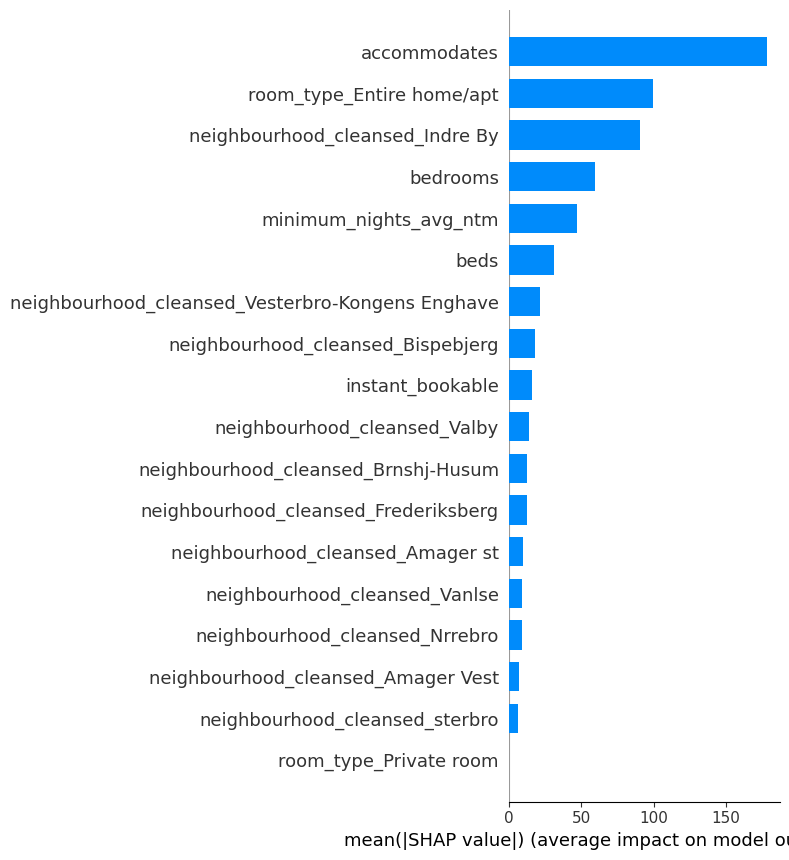

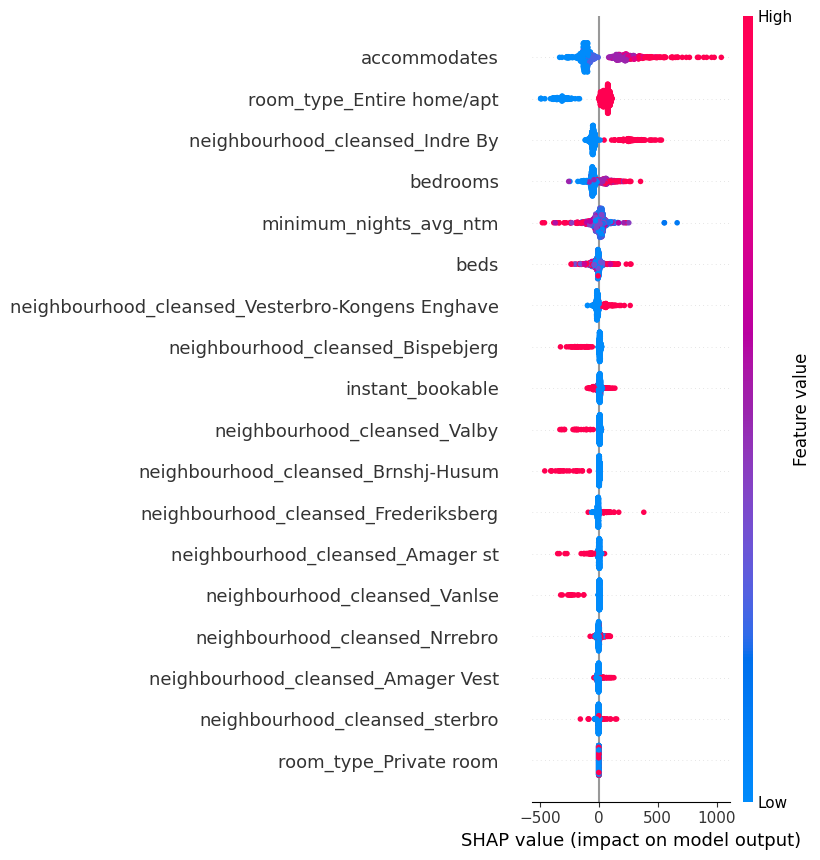

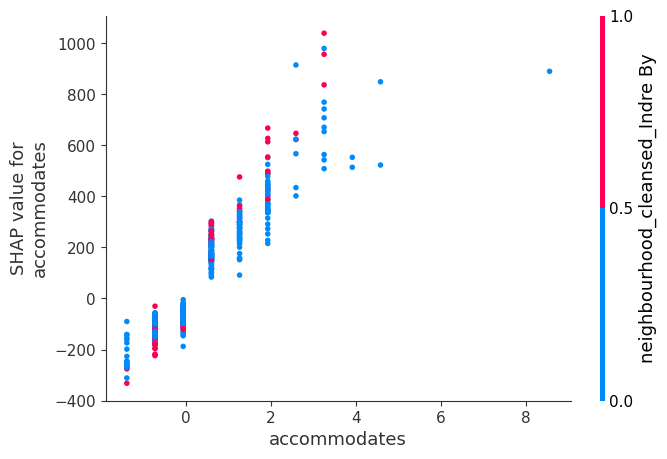

In [ ]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP values
shap.summary_plot(shap_values, X_test)

# Plot dependence for the most important feature
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

### Explanation of SHAP Values

SHAP (SHapley Additive exPlanations) values help us understand the impact of each feature on individual predictions:

1. They show how much each feature contributes, positively or negatively, to the prediction for each instance.
2. They can reveal complex interactions between features.
3. They provide both global interpretability (overall feature importance) and local interpretability (feature impact on individual predictions).

Understanding these values can help hosts and users alike in comprehending the factors influencing Airbnb prices in Copenhagen.

## Save the Model and Preprocessing Objects

Finally, let's save our model and preprocessing objects for future use.

In [ ]:
joblib.dump(model_xgb, 'model_xgb.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(ohe, 'ohe.joblib')

['ohe.joblib']

This notebook demonstrates the end-to-end process of building a price prediction model for Airbnb listings in Copenhagen. We covered data preprocessing, handling missing data through imputation, addressing class imbalance, feature engineering, model training, and interpretation using SHAP values. The model and preprocessing objects are saved for future use or deployment.